In [160]:
import jax 
import jax.numpy as jnp
import equinox as eqx
import optax   
import matplotlib.pyplot as plt
from typing import List

In [161]:
# nr of samples 
N_SAMPLES = 200

# one 1-node input, three 10-node hidden layers, and one 1-node output.
LAYERS = [1, 10, 10, 10, 1]

# set learning rate 
LEARNING_RATE = 0.1 

# set nr epochs 
N_EPOCHS = 30_000

In [162]:
# Data generation. Want to simulate a sinus wave with random feature and random y. 

# setting up random key so we can reproduce results
key = jax.random.key(42)
   

In [163]:
# want keys for features and target. 
key, xkey, ykey = jax.random.split(key, 3) 

(200, 1) (200, 1)


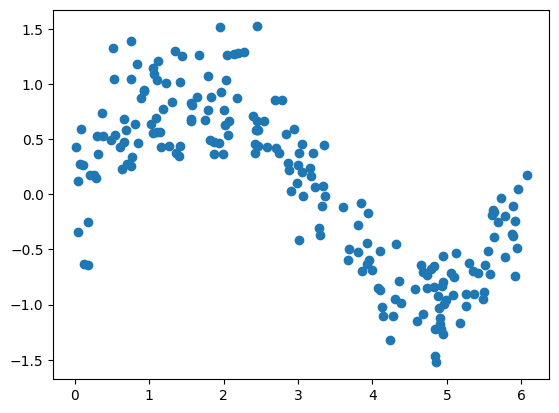

In [164]:
  # pick random values between 0-2pi. x-axis is out feature

# scale of the noise of y 
normal_scale = 0.3

# pick N_SAMPLES uniform distributed values in [0,2pi). shape = (samples, features)
x_samples = jax.random.uniform(xkey, shape=(N_SAMPLES, 1), minval=0.0, maxval=2.0 *jnp.pi)

# evalute sin at x_samples with added scaled normal distributed noise. 
y_samples = jnp.sin(x_samples) + jax.random.normal(ykey, shape=(N_SAMPLES, 1)) * normal_scale

print(x_samples.shape, y_samples.shape)
plt.scatter(x_samples, y_samples)

In [165]:
print(LAYERS)
print(LAYERS[:-1])
print(LAYERS[1:])
print(list(zip(LAYERS[:-1], LAYERS[1:])))

[1, 10, 10, 10, 1]
[1, 10, 10, 10]
[10, 10, 10, 1]
[(1, 10), (10, 10), (10, 10), (10, 1)]


In [166]:
# defining a simple feed-forward multi-layered perceptron. 

class simpleMLP(eqx.Module):
    layers: List[eqx.nn.Linear]

    def __init__(self, list_layer_size, key):
        self.layers = []

        # layer transitions 
        for (in_size,out_size) in zip(list_layer_size[:-1], list_layer_size[1:]):
            key, subkey = jax.random.split(key) # default split into two keys
            self.layers.append(
                eqx.nn.Linear(in_size,out_size, use_bias=True, key = subkey)
            )
           
    def __call__(self,x):
        tmp = x
        for layer in self.layers[:-1]:
            tmp = jax.nn.sigmoid(layer(tmp)) 
        tmp = self.layers[-1](tmp)

        return tmp

In [167]:
model = simpleMLP(LAYERS, key=key)

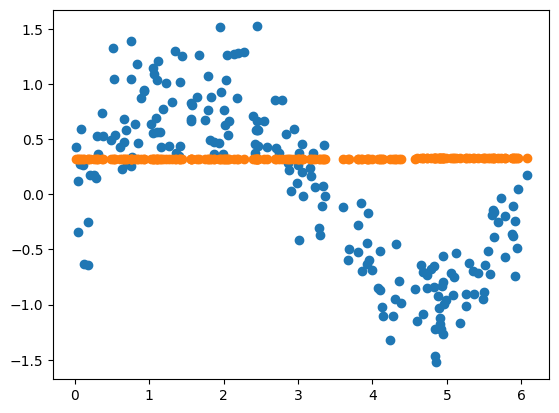

In [168]:
# init prediction
plt.scatter(x_samples, y_samples) # reference  
plt.scatter(x_samples, jax.vmap(model)(x_samples))

# jax.vmap vectorize the model. We can apply the model-function to each x_sample in a vectorized manner.
# x_samples = [e_1, e_2, ..., e_n]
# model_vec(x) = jax.vmap(model) = [model(x), model(x), ..., model(x)], where the lenght = len(x_samples)
# model_vec(x_samples) = [model(e_1), model(e_2), ..., model(e_n)] 

In [169]:
# defining loss function. A loss function a core component of learning. Without it we don't know how well we did given the known values. 
# It is the difference between what you know and the true known value. 

def model_to_loss(model: simpleMLP, x: jax.Array, y: jax.Array) -> jax.Array:
    prediction = jax.vmap(model)(x) 
    difference = prediction - y
    loss = jnp.mean(difference**2)  
    return loss

In [170]:
# now we need to construct the learning process i.e. the optimization process.
# we want the model to learn from the loss and update its weight accordingly. 
# The loss function depends on three things. The model, the features, and the target variable y. 
# But for now let's focus on the model. The loss depends on the parameters of the model. The learning rate, architecture, etc. 
# We want to use a gradient based approach. The holy-grail is to find the global minimum of the loss function. Practially it is impossible due 
# to the fact that the optimization problem is not convex. 
# The best we can do is to find the local-minimum of the loss-function. So we want to use the gradient and walk in the opposite direction of the gradient. The 
#gradient points to the maximum so we walk in the opposite direction to the minimum.   

model_to_loss__and_grad = eqx.filter_value_and_grad(fun = model_to_loss) # differentiate the pure loss function with respect to the first parameter i.e. the model. 


In [171]:
# now we want to create a update rule given the gradient. How should we update the weights? Many different ways to do it. 
opt = optax.sgd(learning_rate=LEARNING_RATE)

# opt weight state  
opt_state = opt.init(eqx.filter(model, eqx.is_array))
 

In [172]:
# define the function that updates the weight state
@eqx.filter_jit # make make_step just-in-time. It will run faster after first run. Calc the grad, updating the grad: forward, and backward pass is where most of compoute is happening. Nice to jit this function. 
def make_step(model, opt_s, x, y):
    loss, grad = model_to_loss__and_grad(model, x,  y) # calc loss and grad given the model, feature samples and target.
    updates, opt_s = opt.update(grad, opt_s,model) # update the grad given the gradients, weight state, and model 
    m = eqx.apply_updates(model, updates) # update the model given the new gradient update. 
    return m, opt_s, loss # return the updated model, the new weight state and the loss. 

In [174]:
# training phase 
import time

loss_history = []
start_time = time.time()

for epoch in range(N_EPOCHS):
    model, opt_state, loss = make_step(model, opt_state, x_samples, y_samples)
    loss_history.append(loss)
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, loss {loss}')
elapsed_time = time.time() - start_time
print(f'time elapsed: {elapsed_time:.2f}s')


Epoch 0, loss 0.624878466129303
Epoch 100, loss 0.5518070459365845
Epoch 200, loss 0.5502560138702393
Epoch 300, loss 0.5480678081512451
Epoch 400, loss 0.544545590877533
Epoch 500, loss 0.5381665229797363
Epoch 600, loss 0.5250779390335083
Epoch 700, loss 0.4944000542163849
Epoch 800, loss 0.4192236661911011
Epoch 900, loss 0.30560755729675293
Epoch 1000, loss 0.252949982881546
Epoch 1100, loss 0.23775199055671692
Epoch 1200, loss 0.2308989018201828
Epoch 1300, loss 0.22629930078983307
Epoch 1400, loss 0.22242304682731628
Epoch 1500, loss 0.2187841683626175
Epoch 1600, loss 0.21522237360477448
Epoch 1700, loss 0.211694598197937
Epoch 1800, loss 0.20820178091526031
Epoch 1900, loss 0.2047608196735382
Epoch 2000, loss 0.20139294862747192
Epoch 2100, loss 0.19811896979808807
Epoch 2200, loss 0.1949564516544342
Epoch 2300, loss 0.19191856682300568
Epoch 2400, loss 0.18901404738426208
Epoch 2500, loss 0.18624722957611084
Epoch 2600, loss 0.18361864984035492
Epoch 2700, loss 0.1811256557703

In [ ]:
# My hardware: Apple M1 Pro. no GPU or MPS on. Only CPU is used.  
# without @eqx.filter_jit of make_step
# Training time:  140.34s

# with @eqx.filter_jit of make_step
# Training time: 4.78s

# 29x improvement 

# Using JAX is a no-brainer. JIT alone is OP. 
# Functions that are run often and are computational intensive MUST be jitted. 

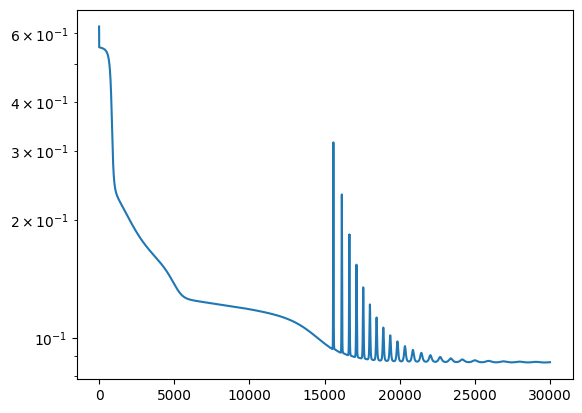

In [173]:
plt.plot(loss_history)
plt.yscale('log')
plt.show()

In [ ]:
# I wonder what these spikes in loss function are. Maybe they are related to the fact the it is sgd.  

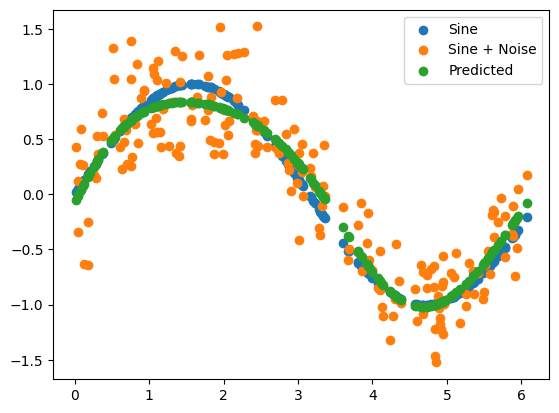

In [141]:
# let's compare the model with true values 
plt.scatter(x_samples, jnp.sin(x_samples), label = "Sine")
plt.scatter(x_samples, y_samples, label = "Sine + Noise")
plt.scatter(x_samples, jax.vmap(model)(x_samples), label = "Predicted")
plt.legend()